## Loading a sub-01 test run:

In [21]:
import pandas as pd
import nibabel as nib
import numpy as np

# sleep_score = pd.read_csv('sleep_data/sleep_scores/sub-01-sleep-stage.tsv', sep='\t')
# sessions = sleep_score['session'].unique()
# data = nib.load(f"sleep_data/sub-{str(0+1).zfill(2)}_{sessions[0]}_bold.nii.gz").get_fdata()
data = nib.load("sub-01_task-rest_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz").get_fdata()
data.shape

(97, 115, 97, 286)

### Defining regions in the data with the Schaefer2018 100Parcels atlas combined with the Tian Subcortex 16Parcels atlas:

In [22]:

atlas = nib.load('sleep_data\Schaefer2018_100Parcels_7Networks_order_Tian_Subcortex_S1_3T_MNI152NLin2009cAsym_2mm.nii.gz')
atlas_data = atlas.get_fdata()
atlas_data = np.round(atlas_data)
atlas_labels = np.unique(atlas_data)
atlas_labels = atlas_labels[1:] # remove 0
atlas_labels = atlas_labels.astype(int)

# Dimensions don't work for the atlas and the 80x80x35 nii data?
# print(atlas_data.shape, data_region.shape)

data_region = np.zeros((data.shape[3], len(atlas_labels)))
for j in range(len(atlas_labels)):
    for k in range(data.shape[3]):
        temp = data[:,:,:,k]
        data_region[k,j] = np.mean(temp[atlas_data == atlas_labels[j]])

### Animating snapshots over time of a slice (idx=21):

......

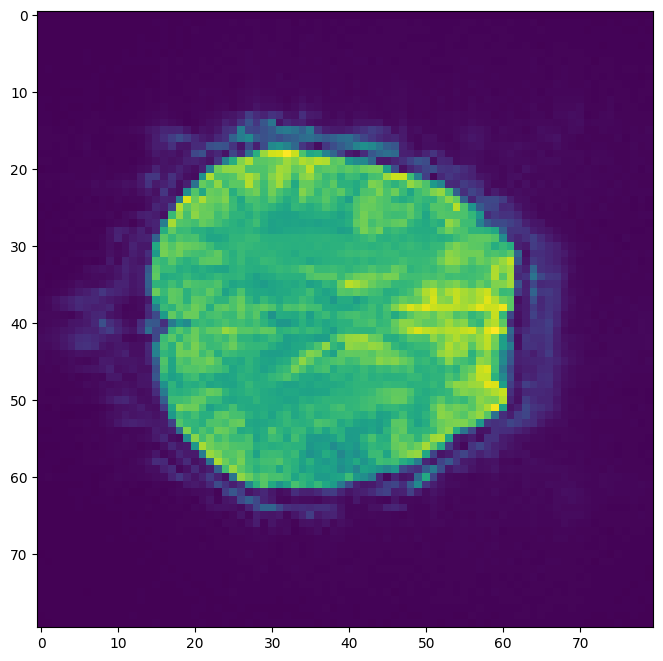

In [23]:
def animate_snapshots(idx, data, fps=30, nSeconds=5):
    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation
    
    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure( figsize=(8,8) )
    snapshots = data[:,:,idx,:]
    a = snapshots[..., 0]
    im = plt.imshow(a)

    def animate_func(i):
        if i % fps == 0:
            print( '.', end ='' )
        im.set_array(snapshots[..., i])
        return [im]

    anim = FuncAnimation(fig, animate_func, frames = nSeconds * fps, interval = 1000 / fps)
    anim.save(f'time-varying-fmri-signal-i_{idx}.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

animate_snapshots(idx=21, data=data)

### Filtering the signals with a bandpass filter:

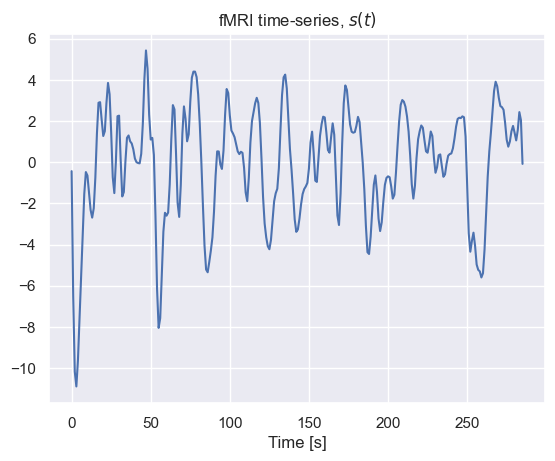

In [26]:
from scipy.signal import butter, filtfilt, hilbert
import matplotlib.pyplot as plt
from seaborn import set_theme
set_theme()

normalized = lambda x: x / np.sum(x)

nyquist = 0.5 * 1/2.1 # code from "proc_data.py"
low = 0.008 / nyquist
high = 0.09 / nyquist
b, a = butter(2, [low, high], btype='band')

data_filtered = np.zeros_like(data_region)
for j in range(116):
    data_filtered[:,j] = filtfilt(b, a, data_region[:,j])

s_series = data_filtered

plt.plot(s_series[:,0])
plt.title("fMRI time-series, $s(t)$")
plt.xlabel('Time [s]');

## LEiDA

### Computing the Hilbert transform and the phase of the filtered signals:

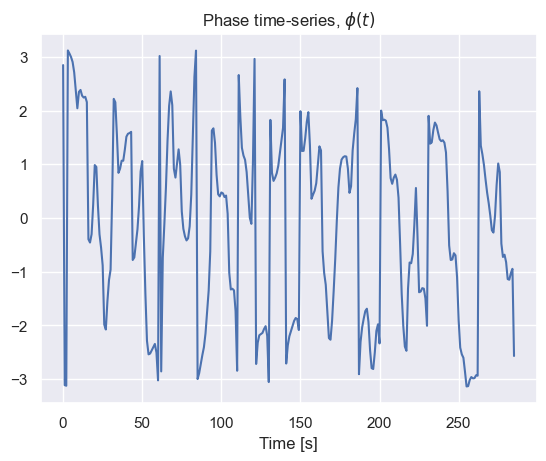

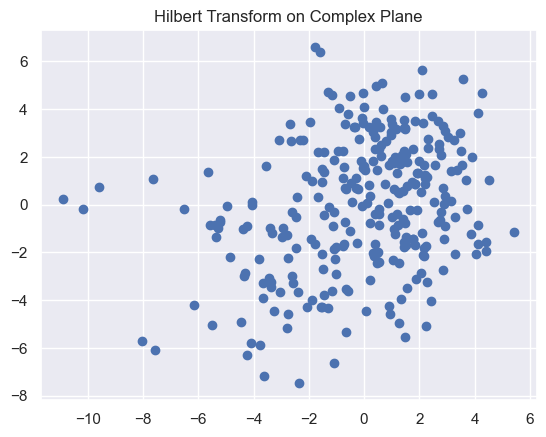

In [34]:
def angle(x): return np.arctan(np.imag(x) / np.real(x))

# def hilbert(u): # https://stackoverflow.com/questions/56380536/hilbert-transform-in-python
#     from scipy.fftpack import fft, ifft
#     N = len(u)
#     U = fft(u) # forward Fourier transform
#     M = N - N//2 - 1
#     U[N//2+1:] = [0] * M # zero out negative frequency components
#     U[1:N//2] = 2 * U[1:N//2] # double fft energy except @ DC0
#     v = ifft(U) # inverse Fourier transform
#     return v

import scipy
from scipy.signal import hilbert

phi_series = np.angle(hilbert(s_series))
plt.plot(phi_series[:,0])
plt.title("Phase time-series, $\phi(t)$")
plt.xlabel('Time [s]');
plt.show()

hilbert_complex = hilbert(s_series)
plt.scatter(np.real(hilbert_complex[:,0]), np.imag(hilbert_complex[:,0]));
plt.title("Hilbert Transform on Complex Plane");

### Computing the instantaneous coherence matrix from the phase:

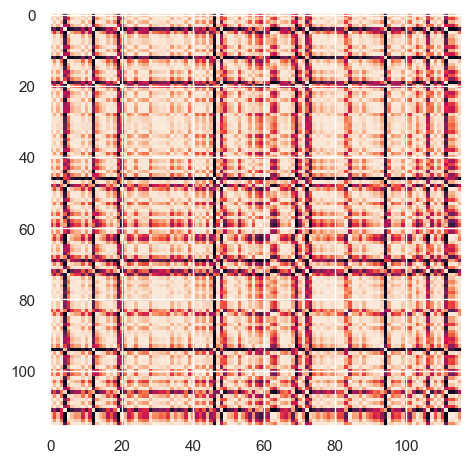

In [37]:
coh_map = lambda x: np.outer(np.cos(x), np.cos(x)) + np.outer(np.sin(x), np.sin(x))
# def coh_map(x):
#     phi_mesh = np.meshgrid(phi_series, phi_series)
#     A = np.cos(phi_mesh[0] - phi_mesh[1]) # phi_tj - phi_tk
#     return A

A = coh_map(phi_series[0])
plt.imshow(A)
plt.tight_layout()

### Computing the eigenvectors of the instantaneous coherence matrix:

Explained Variance
v1: 48.54%	 v2: 51.46%


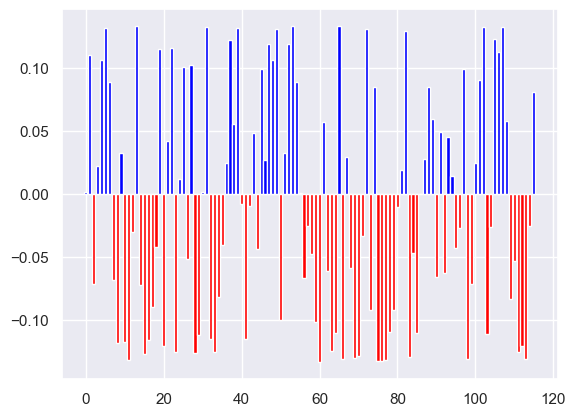

In [40]:
eigval, eigvec = np.linalg.eigh(coh_map(phi_series[100]))
l, v1, v2 = eigval[-2:], eigvec[:,-2:][:,0], eigvec[:,-2:][:,1]

# explained variance as percentage:
print(f"Explained Variance\nv1: {normalized(l)[0]:.2%}\t v2: {normalized(l)[1]:.2%}")

plt.bar(range(len(v1)), v1, color=["red" if v < 0 else "blue" for v in v1]);
# red if under zero, blue if over zero

# Clustering

In [ ]:
from riemannian_kmeans import diametrical_clustering
data_sphere = v1
K = 2
C_dm,part,obj = diametrical_clustering(X=data_sphere,K=K,num_repl=1,init=None)

## NMI for comparisons

In [ ]:
import numpy as np

def calc_MI(Z1, Z2):
    P = Z1 @ Z2.T # joint probability matrix
    PXY = P / np.sum(P) # joint probability matrix normalized
    PXPY = np.outer(np.sum(PXY,axis=1),np.sum(PXY,axis=0)) # product of marginals
    ind = np.where(PXY > 0) # non-zero elements
    MI = np.sum(PXY[ind] * np.log(PXY[ind]/PXPY[ind])) # mutual information
    return MI

def calc_NMI(Z1, Z2):
    # Z1 and Z2 are two partition matrices of size (KxN) where K is number of components and N is number of samples
    NMI = calc_MI(Z1,Z2) / np.mean([calc_MI(Z1,Z1), calc_MI(Z2,Z2)])
    return NMI


# random 4x4 matrix
X = np.random.rand(4,4)
calc_MI(X, X)
